# Install Libraries if Needed (Only Run Once)

In [ ]:
# !pip install -U deepxde

# Import Libraries

In [1]:
# Interactive Plotting

# for jupyter notebooks
%matplotlib notebook 

# for jupyter labs
# %matplotlib widget 

In [8]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import io
import re
import os

import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.integrate import odeint
import matplotlib.tri as tri
from mpl_toolkits import mplot3d

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Laplace Equation with holes for anode and cathod
$$
u_{xx} + u_{yy} = 0, \quad x \in(-1,1), y \in(-1,1)\\
u(-1,y)=u(1,y)=u(x,-1)=u(x,1)\\
u((x+0.5)^2+y^2<r^2) = 1\\
u((x-0.5)^2+y^2<r^2) = -1\\
r = 0.1
$$


Example originally from https://github.com/lululxvi/deepxde/issues/141

# Define PDE

In [3]:
def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_x, dy_y = dy_x[:, 0:1], dy_x[:, 1:]
    dy_xx = tf.gradients(dy_x, x)[0][:, 0:1]
    dy_yy = tf.gradients(dy_y, x)[0][:, 1:]
    return -dy_xx - dy_yy

# Functions to Identify the Various Boundaries

In [4]:
def boundary(_, on_boundary):
    return on_boundary

def boundary_outer(x, on_boundary):
    norm = np.sqrt(x[0]**2 + x[1]**2)
    return on_boundary and (norm > 0.9)

def boundary_cathode(x, on_boundary):
    return on_boundary & (x[0] < 0) & (x[0] > -0.9) & (x[1] < 0.9) & (x[1] > -0.9)

def boundary_anode(x, on_boundary):
    return on_boundary & (x[0] > 0) & (x[0] < 0.9) & (x[1] < 0.9) & (x[1] > -0.9)

# Value at boundaries
def value_outer(x):
    num_data = x.shape[0]
    return np.zeros((num_data,1))

def value_cathode(x):
    num_data = x.shape[0]
    return np.ones((num_data,1)) * 1

def value_anode(x):
    num_data = x.shape[0]
    return -np.ones((num_data,1)) * 1

# Geometry Operators 
Can combine geometries in various ways. Take to geometries geom1 and geom2
## Union (combine domain of geom1 and geom2 for points in either)
```python
geom = geom1 | geom2
```
## Intersection (domain of points in geom1 and geom2)
```python
geom = geom1 & geom2
```
## Difference (exclude geom2 from geom1)
```python
geom = geom1 - geom2
```
## More details
For more details, refer to the geometry class in deepxde https://github.com/lululxvi/deepxde/blob/master/deepxde/geometry/geometry.py



# Define Geometry and BCs

In [5]:
radius = 0.1


bound = dde.geometry.Rectangle([-1,-1], [1,1])
cathode = dde.geometry.Disk([-0.5,0], radius)
anode = dde.geometry.Disk([0.5,0], radius)
geom = bound - cathode - anode
# geom = dde.geometry.CSGDifference(bound, cathode)
# geom = dde.geometry.CSGDifference(geom, anode)
bc_outer = dde.DirichletBC(geom, value_outer, boundary_outer)
bc_cathode = dde.DirichletBC(geom, value_cathode, boundary_cathode)
bc_anode = dde.DirichletBC(geom, value_anode, boundary_anode)

# Define PDE, Net, and Model

In [6]:
data = dde.data.PDE(geom, pde, [bc_outer, bc_cathode, bc_anode], num_domain=60000, num_boundary=6000, num_test=15000)
net = dde.maps.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+60002=60002. 
  warnings.warn("The balance properties of Sobol' points require "
/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+6004=6004. 
  warnings.warn("The balance properties of Sobol' points require "
/home/shawngr/.conda/envs/env/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+6002=6002. 
  warnings.warn("The balance properties of Sobol' points require "


# Define Paths

In [13]:
save_dir = 'Complex_Geometry'
model_name = 'model'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, model_name)
ckpt_path = tf.train.latest_checkpoint(save_dir)
loss_fname = 'loss_complex_geometry.dat'
train_fname = 'train_complex_geometry.dat'
test_fname = 'test_complex_geometry.dat'
loss_path = os.path.join(save_dir, loss_fname)
train_path = os.path.join(save_dir, train_fname)
test_path = os.path.join(save_dir, test_fname)

# ckpt_path = os.path.join(save_dir, 'checkpoint')
# model.save(model_path)

# Load Model

In [14]:
model.compile("adam", lr=1e-3)
model.restore(ckpt_path, verbose=1)

Compiling model...
'compile' took 0.412377 s

Restoring model from Complex_Geometry/model-36483.ckpt ...

INFO:tensorflow:Restoring parameters from Complex_Geometry/model-36483.ckpt


# Train the Network

In [11]:
# Note that we can adjust the loss weights.  Here the PDE loss is has a weight of 1, while the BCs each have a weight of 50
model.compile("adam", lr=0.001, loss_weights = [1, 50, 50, 50])
losshistory, train_state = model.train(epochs=25000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.374265 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.07e-03, 5.13e-01, 4.35e+01, 4.35e+01]    [7.26e-03, 5.14e-01, 4.35e+01, 4.35e+01]    []  
1000      [1.17e+01, 5.30e+00, 2.43e+00, 2.58e+00]    [1.00e+01, 5.30e+00, 2.44e+00, 2.58e+00]    []  
2000      [1.14e+01, 5.28e+00, 2.36e+00, 2.44e+00]    [1.03e+01, 5.28e+00, 2.36e+00, 2.44e+00]    []  
3000      [5.30e+00, 1.82e+00, 1.05e+00, 3.87e-02]    [4.88e+00, 1.82e+00, 1.06e+00, 3.89e-02]    []  
4000      [1.51e-01, 1.76e-02, 2.40e-03, 2.43e-03]    [1.33e-01, 1.76e-02, 2.31e-03, 2.42e-03]    []  
5000      [5.22e-02, 8.15e-03, 9.96e-04, 1.29e-03]    [5.10e-02, 8.11e-03, 1.01e-03, 1.27e-03]    []  
6000      [9.09e-02, 3.83e-03, 1.24e-03, 1.87e-03]    [4.51e-02, 3.85e-03, 1.23e-03, 1.91e-03]    []  
7000      [2.63e-02, 2.21e-03, 8.69e-04, 9.43e-04]    [2.51e-02, 2.23e-03, 8.9

# Save Model

In [12]:
model.save(model_path)

INFO:tensorflow:Complex_Geometry/model-36483.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'Complex_Geometry/model-36483.ckpt'

# Plot Training Performance

Saving loss history to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Complex_Geometry/loss_complex_geometry.dat ...
Saving training data to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Complex_Geometry/train_complex_geometry.dat ...
Saving test data to /gpfs/mira-home/shawngr/ai-science-training-series/07_physics-inspiredAI/Complex_Geometry/test_complex_geometry.dat ...


<IPython.core.display.Javascript object>


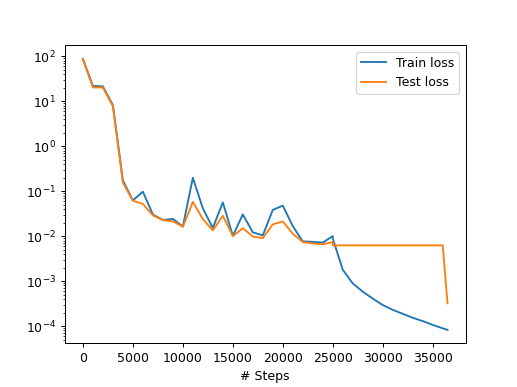

<IPython.core.display.Javascript object>


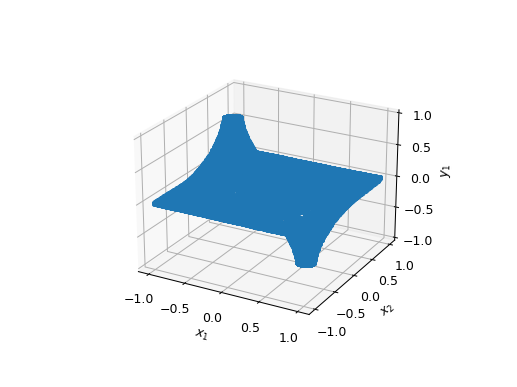

In [15]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True, loss_fname=loss_path, train_fname=train_path, test_fname=test_path)

# Get Predictions on Test Data

In [16]:

u_pred = model.predict(data.test_x).flatten()

In [17]:
x = data.test_x[:,0]
y = data.test_x[:,1]


# Plot Results

<IPython.core.display.Javascript object>


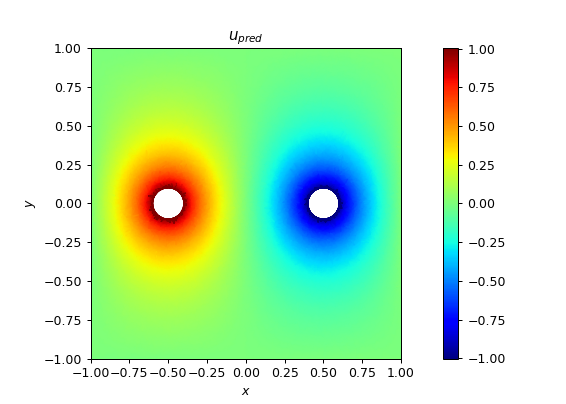

In [18]:

fig = plt.figure(figsize=(7,5))

triang = tri.Triangulation(x, y)
triang.set_mask((np.hypot((x[triang.triangles].mean(axis=1) - 0.5), y[triang.triangles].mean(axis=1)) < radius ) | (np.hypot((x[triang.triangles].mean(axis=1) + 0.5), y[triang.triangles].mean(axis=1)) < radius))

# plt.pcolor(data.test_x, u_pred, cmap='jet', shading='gouraud')
tpc = plt.tripcolor(triang, u_pred, cmap='jet', shading='gouraud')

plt.colorbar(tpc)
plt.axis('square')

plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$u_{pred}$')


plt.show()

<IPython.core.display.Javascript object>


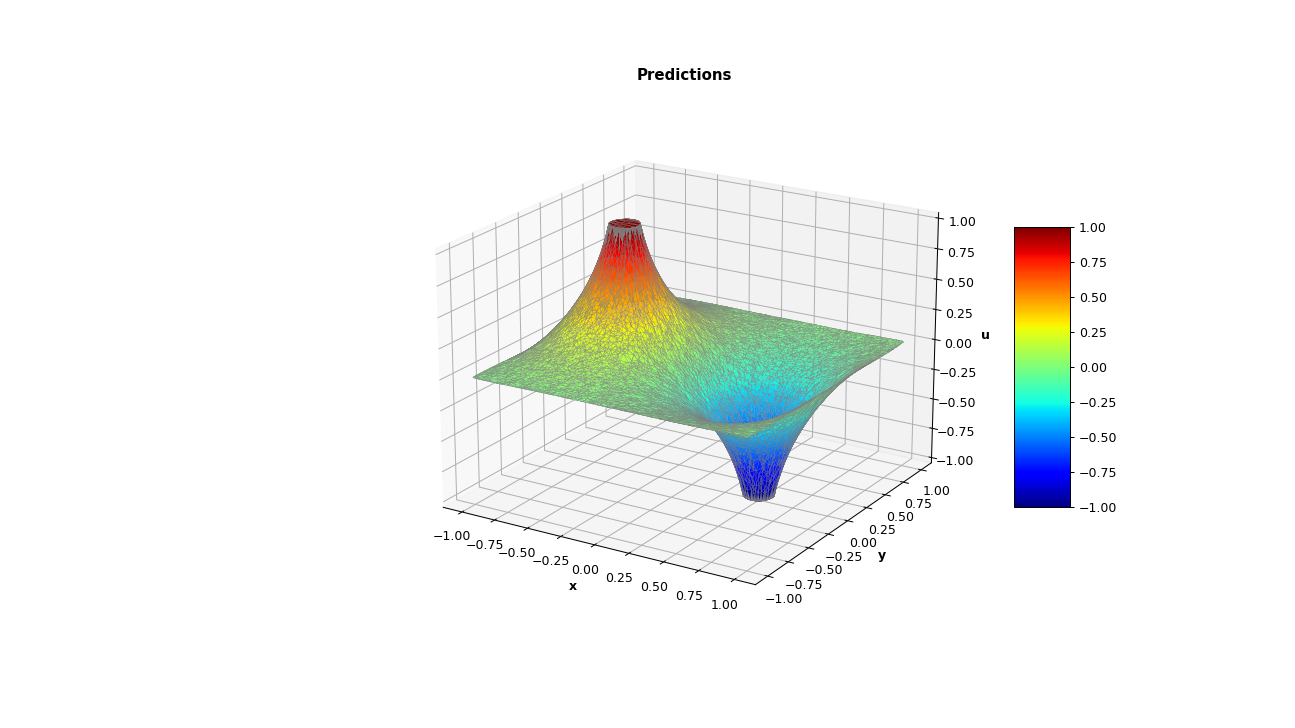

In [19]:
fig = plt.figure(figsize =(16, 9)) 
ax = plt.axes(projection ='3d') 
trisurf = ax.plot_trisurf(x, y, u_pred,
                         cmap = 'jet',
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey') 
fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
ax.set_title('Predictions', fontweight='bold')
# Adding labels
ax.set_xlabel('x', fontweight ='bold')
ax.set_ylabel('y', fontweight ='bold')
ax.set_zlabel('u', fontweight ='bold')
plt.show()